In [1]:
# Comparison of pvlib's uncertainty modelling to SunSolve's new P90 tool.
# Testing how adding error functions to pvlib inputs and then repeatedly simulating
# the system with random error gives a distribution of yields.

In [1]:
# Set up working folder
import os, sys
if 'google.colab' in sys.modules:
    from google.colab import drive, data_table
    # Mount Google Drive
    drive.mount('/content/drive')

    # Change the working directory to wherever you have saved this file on your drive
    folder = '/content/drive/MyDrive/Colab Notebooks/Uncertainty Colabs'
    os.chdir(folder)
else:
    # If Google drive is not available, then run from the current folder
    folder = os.getcwd()

# Check if the necessary files/folders are available, or clone them from GitHub
necessary_files = ['Data', 'SunSolveLogo.svg', 'README.md', 'pvl_p90_client-0.1.0.142+dev-py3-none-any.whl', 'UncertaintyFunctions.ipynb']
if not all(i in os.listdir() for i in necessary_files):
    if not 'SunSolve P90' in os.listdir() or not all(i in os.listdir('SunSolve P90') for i in necessary_files):
        os.mkdir('SunSolve P90')
        !git clone https://github.com/SF-PVL/P90-Notebook.git 'SunSolve P90'
    os.chdir('SunSolve P90')

# Install the P90 client (a pip dependency error may occur for protobuf, but can be ignored)
%pip install pvl_p90_client-0.1.0.142+dev-py3-none-any.whl --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load helper file functions, log in to your PV Lighthouse account and start running a test simulation
%run "UncertaintyFunctions.ipynb"

# Set uncertainty simulation constants (time scales with N_SIMS*N_YEARS, 5000*5 ≈ 120 seconds)
N_SIMS = 1000    # Need to reduce this here, as pvlib will take hours to do thousands of simulations, generally.
N_YEARS = 4
simulation_options = build_simulation_options(number_of_years=N_YEARS, number_of_simulations=N_SIMS)

# Set P-value preferences
p_values = [50, 90, 95]     # e.g. [50, 90, 95] -> P50, P90, P95
p_min = 0.75                # The minimum fraction of P50 to be binned on histograms
p_delta = 0.01              # The bin size for histograms
result_options = build_result_options(p_min=p_min, p_delta=p_delta, p_values=p_values)

# Collect weather data: sydney.pvw file is provided as part of the source
weather_file_path = "Data/sydney.pvw"
weather_data = load_weather_data_from_pvw_file(weather_file_path)

# Set up system
module_info = build_module_info(length=2.0, width=1.0, bifaciality=0.8)

system_info = build_system_info(
    modules_per_string=1,
    fallback_module_tilt_in_degrees=30,
    number_of_inverters=1,
    num_strings_per_inverter=1,
    row_pitch_in_m=5.6,
    azimuth_in_degrees=90            # Direction modules face for positive tilt. 0=North, 90=East, 180=South
)

electrical_settings = build_electrical_settings(
    inverter_efficiency=0.98,
    module_to_module_mismatch=0.01,
    string_wiring_loss=0.01,
    inverter_wiring_loss=0.01,
    max_power_tracking_loss=0.0
)

thermal_settings = build_thermal_settings(uc=25, uv=1.2, alpha=0.9)

optical_settings = build_optical_settings(fallback_albedo=0.2,
    fallback_soiling_front=0.02, fallback_soiling_rear=0.002,
    isotropic_multiplier_front=1)

operational_settings = build_operational_settings(annual_degradation_rate=0.003,
    curtailment=0.02, availability=0.98)

2025-09-30 17:01:58,859 - INFO - Connected to P90 service at middleware.pvlighthouse.com.au
2025-09-30 17:01:58,975 - INFO - P90 client connection closed
2025-09-30 17:01:58,975 - INFO - P90 client connection closed


Connecting to PV Lighthouse...
Authenticating...
Authentication successful!
Loading time step data...
Loaded 8760 weather data points


In [27]:
# View irradiance data for specific day
interactive_weather_plot(weather_file_path, weather_data)

interactive(children=(IntSlider(value=1, description='Day of year:', max=365, min=1), Output()), _dom_classes=…

## Set Up Modifiers to Introduce Uncertainty

Set up input distributions (probability distribution functions)

Targets: ('ModifierTarget.____')

GHI, DiffuseFraction, WindSpeed, Temperature, etaSTC, FrontSpectral, FrontSoiling, RearSoiling, Uc, Uv, Alpha, Degradation, Availability, ExtraYearly, HayModel, UndulatingGround, OpticalTracking

sim_pdf: site-to-site error, affecting all years; year_pdf: year-to-year error; time_pdf: hour-to-hour error

Note: for Degradation, etaSTC, FrontSoiling and RearSoiling, the sim_pdf value is not a multiplier, but sets the distribution of values. Degradation is a rate/year and should be negative, soiling should be positive.

In [28]:
# Interactive probability density function (pdf) viewer, to help define your error functions
interactive_distribution_plot()

In [5]:
distribution_list = [
    create_distribution(DistributionInput.AnnualDegradationRate, simToSim=['SkewedGaussian', -6, 0.01, 0.002], yearToYear=['Gaussian', 1, 0.04]),
    create_distribution(DistributionInput.GHI, simToSim=['Gaussian', 1, 0.06], yearToYear=['Gaussian', 1, 0.04], stepToStep=['SkewedGaussian', -2, 0.95, 0.05]),
    create_distribution(DistributionInput.Temperature, simToSim=['Gaussian', 1, 0.06], yearToYear=['Gaussian', 1, 0.04], stepToStep=['SkewedGaussian', -2, 0.95, 0.05]),
    create_distribution(DistributionInput.SoilingFront, simToSim=['Weibull', 0, 0.04, 2], yearToYear=['Gaussian', 0.08, 0.04]),
]

## Send Request and Start SunSolve P90 Analysis

In [6]:
# Build and send request
p90_request = build_request(
    time_step_data=weather_data,
    module=module_info,
    system=system_info,
    electrical=electrical_settings,
    optical=optical_settings,
    thermal=thermal_settings,
    operational=operational_settings,
    distributions=distribution_list,
    simulation_options=simulation_options,
    result_options=result_options
)
t_start = time.time()
summary, used_inputs = request_analysis(p90_request)
t_sunsolve = time.time()-t_start

2025-09-30 13:33:17,912 - INFO - Connected to P90 service at middleware.pvlighthouse.com.au
2025-09-30 13:33:18,215 - INFO - Starting P90 analysis request
2025-09-30 13:33:18,215 - INFO - Starting P90 analysis request


Starting uncertainty analysis...


2025-09-30 13:33:26,923 - INFO - === P90 Analysis Inputs Used ===
2025-09-30 13:33:26,924 - INFO - Module: Length=2.000m, Width=1.000m, HeightAboveGround=1.500m, PowerRatingAtSTC=460.0W, CellToCellMismatch=0.0040, EfficiencyTempCoeff=0.002950, Bifaciality=0.800
2025-09-30 13:33:26,925 - INFO - System: ModulesPerString=1, StringsPerInverter=1, NumberOfInverters=1
2025-09-30 13:33:26,926 - INFO - System Geometry: RowPitch=5.60m, ModuleAzimuth=90.0°, FallbackModuleTilt=30.0°
2025-09-30 13:33:26,928 - INFO - Electrical Efficiencies: InverterEff=0.9800, ModuleToModuleMismatch=0.0100, StringWiringLoss=0.0100
2025-09-30 13:33:26,924 - INFO - Module: Length=2.000m, Width=1.000m, HeightAboveGround=1.500m, PowerRatingAtSTC=460.0W, CellToCellMismatch=0.0040, EfficiencyTempCoeff=0.002950, Bifaciality=0.800
2025-09-30 13:33:26,925 - INFO - System: ModulesPerString=1, StringsPerInverter=1, NumberOfInverters=1
2025-09-30 13:33:26,926 - INFO - System Geometry: RowPitch=5.60m, ModuleAzimuth=90.0°, Fall

Progress: 100.00%
Progress: 100.00%


2025-09-30 13:33:35,659 - INFO - Received P90 analysis summary



Analysis complete! Summary contains 12 yearly P-values
Request took 17 s, running 4000 simulations in total (229 sims/s)
Analysis complete! Summary contains 12 yearly P-values
Request took 17 s, running 4000 simulations in total (229 sims/s)


2025-09-30 13:33:35,661 - INFO - P90 client connection closed


## SunSolve P90 Results
Results are expressed in terms of 'P50 deviation' (normalised yield), where a value of 1 is the P50 yield for that year.

Absolute yield estimates are not provided, but [SunSolve Yield](https://sunsolve.info/yield/) can be used to estimate this accurately.

A P90 might have a P50 deviation of '0.88' - this means that 95% of simulated yields were at least 88% of the P50 yield.

The P50 yields of each year are also compared, where the P50 deviation is displayed relative to the year 1 P50 yield.

[Useful reading](https://apvi.org.au/solar-research-conference/wp-content/uploads/2024/12/McIntosh_K_Asymmetry_in_the_energy_yield_forecasts_for_PV_power_plants.pdf)

Note: The first and last bins of the histograms are wider than the others, including all values to their left and right, respectively.

In [7]:
plot_yearly_P50_Values(summary)
plot_interactive_histogram(summary, p_min=p_min, p_delta=p_delta)

interactive(children=(IntSlider(value=1, description='Year:', max=4, min=1), Output()), _dom_classes=('widget-…

In [8]:
plot_pvalues(summary)

In [43]:
# Monte Carlo Yield Analysis with Uncertainties (Matching SunSolve P90)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skewnorm
from scipy.stats import weibull_min
import pvlib

# Extract system parameters from used_inputs
module_power = used_inputs.Module.PowerRatingAtSTCInW
power_temp_coeff = used_inputs.Module.ModuleEfficiencyTemperatureCoefficient
degradation_rate = used_inputs.Operation.AnnualDegradationRate
soiling_front = used_inputs.Optical.FallbackSoilingFront
soiling_rear = used_inputs.Optical.FallbackSoilingRear
inverter_efficiency = used_inputs.Electrical.InverterEfficiency
module_tilt = used_inputs.System.FallbackModuleTiltInDegrees
module_azimuth = used_inputs.System.ModuleAzimuthInDegrees
modules_per_string = used_inputs.System.ModulesPerString
strings_per_inverter = used_inputs.System.StringsPerInverter
num_inverters = used_inputs.System.NumberOfInverters
Uc = used_inputs.Thermal.Uc
Uv = used_inputs.Thermal.Uc
alpha_absorption = used_inputs.Thermal.Alpha
albedo = used_inputs.Optical.FallbackAlbedo
cell_mismatch = used_inputs.Module.CellToCellMismatch
module_mismatch = used_inputs.Electrical.ModuleToModuleMismatch
string_mismatch = used_inputs.Electrical.StringToStringMismatch
inverter_mismatch = used_inputs.Electrical.InverterToInverterMismatch
string_wiring_loss = used_inputs.Electrical.StringWiringLoss
inverter_wiring_loss = used_inputs.Electrical.InverterWiringLoss
curtailment = used_inputs.Operation.Curtailment

# Extract view factor shading calculation inputs
module_length = used_inputs.Module.LengthInM
module_width = used_inputs.Module.WidthInM
module_height = used_inputs.Module.HeightAboveGroundInM
bifaciality = used_inputs.Module.Bifaciality
row_pitch = used_inputs.System.RowPitchInM
gcr = module_width / row_pitch  # Ground coverage ratio
module_efficiency = module_power / (1000*module_width*module_length)

# Calculate diffuse shading factor now using view factor model
# (since system is fixed, no need to solve it in-loop)
masking_angle = pvlib.shading.masking_angle_passias(module_tilt, gcr)
diffuse_shading_factor = pvlib.shading.sky_diffuse_passias(masking_angle)

# Load base weather data
weather_base = pd.read_csv(r'Data/Sydney.csv', skiprows=1, parse_dates=[0], date_format='%d/%m/%Y %H:%M')
weather_base.columns = ['datetime', 'solar_azimuth', 'solar_zenith', 'temp_air', 'dhi', 'ghi', 'dni', 'wind_speed', 'tilt']
weather_base.set_index('datetime', inplace=True)


# System parameters
latitude, longitude, altitude = -33.865, 151.300, 50
tz = "Etc/GMT+10"
module_specs = {'pmp': module_power, 'gamma_pmp': -power_temp_coeff}
inverter_specs = {'pdc0': 5200, 'eta_inv_nom': inverter_efficiency}
site_location = pvlib.location.Location(latitude, longitude, tz=tz, name='Sydney, AU')
solpos = site_location.get_solarposition(weather_base.index)
cs = site_location.get_clearsky(weather_base.index)

# Initialize results storage
annual_yields = np.zeros((N_SIMS, N_YEARS))
fig_cols = min(4, N_YEARS) if N_YEARS < 25 else 5

# Create bin list from p_min and p_delta.
n_p = len(summary.YearlyHistogram[0].bins)
p_max = (1+(1-p_min))-p_delta       # -p_delta to avoid needing n_p+1 bins
p_bins = np.linspace(p_min, p_max, n_p)

t_start = time.time()    # get the start time

uncertainties = parse_distribution_list(distribution_list)

print("Parsed uncertainties:")
for key, value in uncertainties.items():
    print(f"{key}: {value}")

print(f"\nRunning Monte Carlo analysis: {N_SIMS} simulations × {N_YEARS} years...")
print(f"Module Power: {module_power:.4g}W, Tilt: {module_tilt:.3g}°, Azimuth: {module_azimuth:.3g}°")
print(f"Degradation: {degradation_rate*100:.1f}%/year, Soiling: {soiling_front*100:.1f}%")

# Monte Carlo simulation loops
for sim in range(N_SIMS):
    if N_SIMS > 5 and (sim + 1) % (N_SIMS//5) == 0:
        print(f"Simulation {sim + 1}/{N_SIMS}")
    
    # Simulation-level uncertainties (same for all years in this simulation)
    ghi_sim_factor = generate_random_value(uncertainties.get('GHI', {}).get('sim_to_sim'))
    diffuse_sim_factor = generate_random_value(uncertainties.get('DiffuseFraction', {}).get('sim_to_sim'))
    temp_sim_factor = generate_random_value(uncertainties.get('Temperature', {}).get('sim_to_sim'))
    wind_sim_factor = generate_random_value(uncertainties.get('WindSpeed', {}).get('sim_to_sim'))
    degradation_sim = generate_random_value(uncertainties.get('AnnualDegradationRate', {}).get('sim_to_sim'))
    soiling_front_sim = generate_random_value(uncertainties.get('SoilingFront', {}).get('sim_to_sim'))
    availability_sim = generate_random_value(uncertainties.get('Availability', {}).get('sim_to_sim'))
    
    for year in range(N_YEARS):
        # Year-level uncertainties (vary each year)
        ghi_year_factor = generate_random_value(uncertainties.get('GHI', {}).get('yr_to_yr'))
        diffuse_year_factor = generate_random_value(uncertainties.get('DiffuseFraction', {}).get('yr_to_yr'))
        temp_year_factor = generate_random_value(uncertainties.get('Temperature', {}).get('yr_to_yr'))
        wind_year_factor = generate_random_value(uncertainties.get('WindSpeed', {}).get('yr_to_yr'))
        degradation_year = generate_random_value(uncertainties.get('AnnualDegradationRate', {}).get('yr_to_yr'))
        soiling_front_year = generate_random_value(uncertainties.get('SoilingFront', {}).get('yr_to_yr'))
        availability_year = generate_random_value(uncertainties.get('Availability', {}).get('yr_to_yr'))
        
        # Copy weather data for modifications
        modified_weather = weather_base.copy()
        
        # Apply step-to-step uncertainties to each timestep
        n_timesteps = len(modified_weather)
        ghi_step_factors = np.array([generate_random_value(uncertainties.get('GHI', {}).get('step_to_step')) for _ in range(n_timesteps)])
        diffuse_step_factors = np.array([generate_random_value(uncertainties.get('DiffuseFraction', {}).get('step_to_step')) for _ in range(n_timesteps)])
        temp_step_factors = np.array([generate_random_value(uncertainties.get('Temperature', {}).get('step_to_step')) for _ in range(n_timesteps)])
        wind_step_factors = np.array([generate_random_value(uncertainties.get('WindSpeed', {}).get('step_to_step')) for _ in range(n_timesteps)])
        
        # Apply all uncertainties to weather data
        modified_weather['ghi'] = modified_weather['ghi'] * ghi_sim_factor * ghi_year_factor * ghi_step_factors
        modified_weather['temp_air'] = modified_weather['temp_air'] * temp_sim_factor * temp_year_factor * temp_step_factors - 273.15     # Convert from Kelvin to celsius at the end
        modified_weather['wind_speed'] = modified_weather['wind_speed'] * wind_sim_factor * wind_year_factor * wind_step_factors
        
        # Apply diffuse fraction uncertainty (affects DHI relative to GHI; then DNI is calculated from both)
        diffuse_fraction = modified_weather['dhi'] / (modified_weather['ghi'] + 1e-10)  # Avoid division by zero
        diffuse_fraction_modified = diffuse_fraction * diffuse_sim_factor * diffuse_year_factor * diffuse_step_factors
        diffuse_fraction_modified = np.clip(diffuse_fraction_modified, 0, 1)  # Keep between 0 and 1
        modified_weather['dhi'] = modified_weather['ghi'] * diffuse_fraction_modified
        modified_weather['dni'] = (modified_weather['ghi']-modified_weather['dhi']) / np.cos(np.radians(solpos['apparent_zenith']))
        
        # Calculate row-to-row beam shading using shaded_fraction1d
        shaded_fraction = pvlib.shading.shaded_fraction1d(
            solar_zenith=solpos['apparent_zenith'],
            solar_azimuth=solpos['azimuth'], 
            axis_azimuth=module_azimuth,
            shaded_row_rotation=module_tilt,
            collector_width=module_width,
            pitch=row_pitch,
            axis_tilt=module_tilt
        )

        # Apply beam shading to DNI and diffuse shading to DHI
        beam_shading_factor = 1 - shaded_fraction
        modified_weather['dni'] *= beam_shading_factor
        modified_weather['dhi'] *= diffuse_shading_factor

        # Calculate irradiance
        extraterrestrial_dni = pvlib.irradiance.get_extra_radiation(modified_weather.index)
        total_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance(module_tilt, module_azimuth, solpos['apparent_zenith'],
            solpos['azimuth'], gcr, module_width, row_pitch, modified_weather['ghi'], modified_weather['dhi'], modified_weather['dni'],
            albedo, model='haydavies', dni_extra=extraterrestrial_dni, iam_front=1.0, iam_back=1.0, bifaciality=bifaciality,
            shade_factor=-0.02, transmission_factor=0)
        
        # Apply soiling losses (use SunSolve values)
        soiling_factor_front = 1 - (soiling_front * soiling_front_sim * soiling_front_year)
        soiling_factor_rear = 1 - soiling_rear
        effective_irradiance = total_irradiance['poa_front'] * soiling_factor_front + \
              total_irradiance['poa_back'] * bifaciality * soiling_factor_rear
        
        # Calculate cell temperature
        cell_temp = pvlib.temperature.pvsyst_cell(
            effective_irradiance, modified_weather['temp_air'], modified_weather['wind_speed'],
            u_c=Uc, u_v=Uv, module_efficiency=module_efficiency, alpha_absorption=alpha_absorption)

        # Calculate DC power
        array_rated_power = module_power * modules_per_string * strings_per_inverter
        module_power_dc = pvlib.pvsystem.pvwatts_dc(
            effective_irradiance, cell_temp, module_power, 
            module_specs['gamma_pmp'], temp_ref=25) * (1-cell_mismatch)
        
        string_power_dc = module_power_dc * modules_per_string * (1-module_mismatch) * (1-string_wiring_loss)
        array_power_dc = string_power_dc * strings_per_inverter * num_inverters * (1-inverter_mismatch) * (1-string_mismatch) * (1-inverter_wiring_loss)

        # Apply degradation (use SunSolve values)
        degradation_factor = (1 - (degradation_rate * degradation_sim * degradation_year)) ** (year + 1)
        dc_power_degraded = array_power_dc * degradation_factor
        
        # Calculate AC power
        ac_power = array_power_dc * inverter_efficiency
        
        # Apply availability factor and curtailment
        availability_factor = availability_sim * availability_year
        ac_power_final = ac_power * availability_factor * (1-curtailment)
        
        annual_yields[sim, year] = ac_power_final.sum() / 1000  # kWh

print("Monte Carlo analysis complete!")

t_pvlib = time.time()-t_start    # get the request time in seconds
n_total = N_SIMS*N_YEARS
print(f"Request (pvlib) took {round(t_pvlib)} s, running {n_total} simulations in total ({round(n_total/t_pvlib, 2)} sims/s)")
print(f"SunSolve P90 took {t_sunsolve:g} s ({round(n_total/t_sunsolve,2)} sims/s)")

# Calculate statistics
yield_mean = np.mean(annual_yields, axis=0)
yield_std = np.std(annual_yields, axis=0)
yield_p10 = np.percentile(annual_yields, 90, axis=0)
yield_p90 = np.percentile(annual_yields, 10, axis=0)

print(f"\n=== Monte Carlo Results Summary ===")
print(f"Year 1 - Mean: {yield_mean[0]:.1f} kWh, Std: {yield_std[0]:.1f} kWh")
print(f"Year {N_YEARS} - Mean: {yield_mean[-1]:.1f} kWh, Std: {yield_std[-1]:.1f} kWh")
print(f"Total degradation over {N_YEARS} years: {((yield_mean[0] - yield_mean[-1])/yield_mean[0]*100):.1f}%")

Parsed uncertainties:
AnnualDegradationRate: {'sim_to_sim': ['SkewedGaussian', -6.0, 0.01, 0.002], 'yr_to_yr': ['Gaussian', 1.0, 0.04], 'step_to_step': None}
GHI: {'sim_to_sim': ['Gaussian', 1.0, 0.06], 'yr_to_yr': ['Gaussian', 1.0, 0.04], 'step_to_step': ['SkewedGaussian', -2.0, 0.95, 0.05]}
Temperature: {'sim_to_sim': ['Gaussian', 1.0, 0.06], 'yr_to_yr': ['Gaussian', 1.0, 0.04], 'step_to_step': ['SkewedGaussian', -2.0, 0.95, 0.05]}
SoilingFront: {'sim_to_sim': ['Weibull', 0.04, 2.0], 'yr_to_yr': ['Gaussian', 0.08, 0.04], 'step_to_step': None}

Running Monte Carlo analysis: 1000 simulations × 4 years...
Module Power: 460W, Tilt: 30°, Azimuth: 90°
Degradation: 0.3%/year, Soiling: 2.0%
Simulation 200/1000
Simulation 200/1000
Simulation 400/1000
Simulation 400/1000
Simulation 600/1000
Simulation 600/1000
Simulation 800/1000
Simulation 800/1000
Simulation 1000/1000
Simulation 1000/1000
Monte Carlo analysis complete!
Request (pvlib) took 2083 s, running 4000 simulations in total (1.92 sims

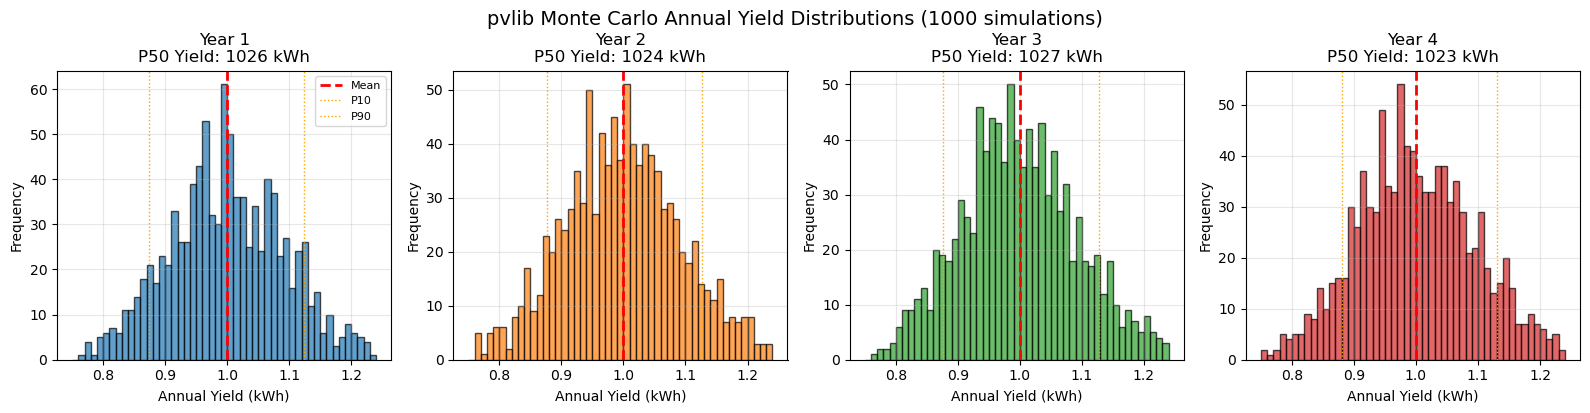


=== Annual Statistics (kWh) ===
Year	Mean	Std	P10	P90	Range
1\t1026\t101\t1154\t897\t-256
2\t1024\t100\t1155\t898\t-257
3\t1027\t101\t1159\t900\t-259
4\t1023\t100\t1158\t900\t-257


In [44]:
# Create histogram plots for each year
fig, axes = plt.subplots(math.ceil(N_YEARS/fig_cols), fig_cols, figsize=(16, 4*N_YEARS//fig_cols))
if N_YEARS > 1:
    axes = axes.flatten()
else:
    axes = [axes]

years = range(1, N_YEARS + 1)
for i, year in enumerate(years):
    axes[i].hist(annual_yields[:, i]/yield_mean[i], bins=p_bins, alpha=0.7, color=f'C{i%10}', edgecolor='black')
    axes[i].set_title(f'Year {year}\nP50 Yield: {yield_mean[i]:.0f} kWh')
    axes[i].set_xlabel('Annual Yield (kWh)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)
    
    # Add statistics text
    axes[i].axvline(yield_mean[i]/yield_mean[i], color='red', linestyle='--', linewidth=2, label='Mean')
    axes[i].axvline(yield_p10[i]/yield_mean[i], color='orange', linestyle=':', linewidth=1, label='P10')
    axes[i].axvline(yield_p90[i]/yield_mean[i], color='orange', linestyle=':', linewidth=1, label='P90')
    
    if i == 0:  # Add legend to first subplot
        axes[i].legend(fontsize=8)

plt.tight_layout()
plt.suptitle(f'pvlib Monte Carlo Annual Yield Distributions ({N_SIMS} simulations)', y=1.02, fontsize=14)
plt.show()

# Summary statistics table
print(f"\n=== Annual Statistics (kWh) ===")
print("Year\tMean\tStd\tP10\tP90\tRange")
for i, year in enumerate(years):
    print(f"{year}\\t{yield_mean[i]:.0f}\\t{yield_std[i]:.0f}\\t{yield_p10[i]:.0f}\\t{yield_p90[i]:.0f}\\t{yield_p90[i]-yield_p10[i]:.0f}")

# Store results for comparison
pvlib_results = {
    'annual_yields': annual_yields,
    'yield_mean': yield_mean,
    'yield_p90': yield_p90,
    'yield_p10': yield_p10
}

In [ ]:
# Convert pvlib data into an UncertaintySummary to match the SunSolve P90 data
create_pvlib_summary(annual_yields, N_YEARS, p_bins)
# Plot pvlib and SunSolve summaries
plot_interactive_histogram(pvlib_summary)
plot_interactive_histogram(summary) # SunSolve P90

interactive(children=(IntSlider(value=1, description='Year:', max=4, min=1), Output()), _dom_classes=('widget-…

interactive(children=(IntSlider(value=1, description='Year:', max=4, min=1), Output()), _dom_classes=('widget-…

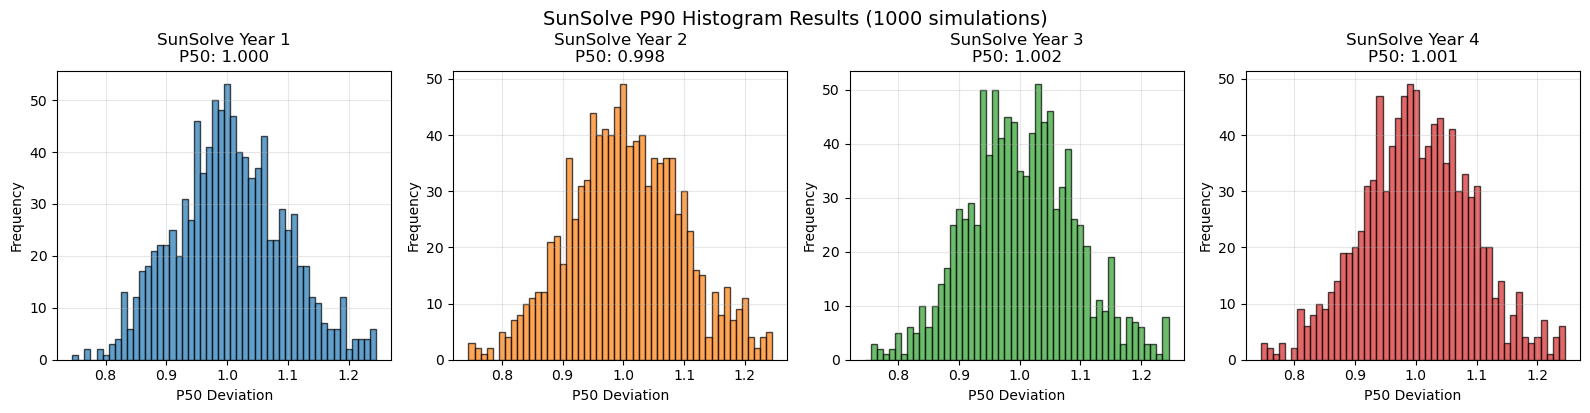

In [47]:
# SunSolve P90 Histogram Comparison
import matplotlib.pyplot as plt
import numpy as np

# Extract SunSolve histogram data
fig, axes = plt.subplots(math.ceil(N_YEARS/fig_cols), fig_cols, figsize=(16, 4*N_YEARS//fig_cols))
if N_YEARS > 1:
    axes = axes.flatten()
else:
    axes = [axes]

years = range(1, N_YEARS + 1)
for i, year in enumerate(years):
    if i < len(summary.YearlyHistogram):
        # Get SunSolve histogram data
        hist_data = summary.YearlyHistogram[i]
        bin_counts = np.array(hist_data.bins)
        
        # Plot SunSolve histogram
        axes[i].bar(p_bins, bin_counts, alpha=0.7, color=f'C{i%10}', edgecolor='black', width=0.01)
        axes[i].set_title(f'SunSolve Year {year}\nP50: {summary.YearlyP50Deviation[i].Value:.3f}')
        axes[i].set_xlabel('P50 Deviation')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'SunSolve P90 Histogram Results ({N_SIMS} simulations)', y=1.02, fontsize=14)
plt.show()

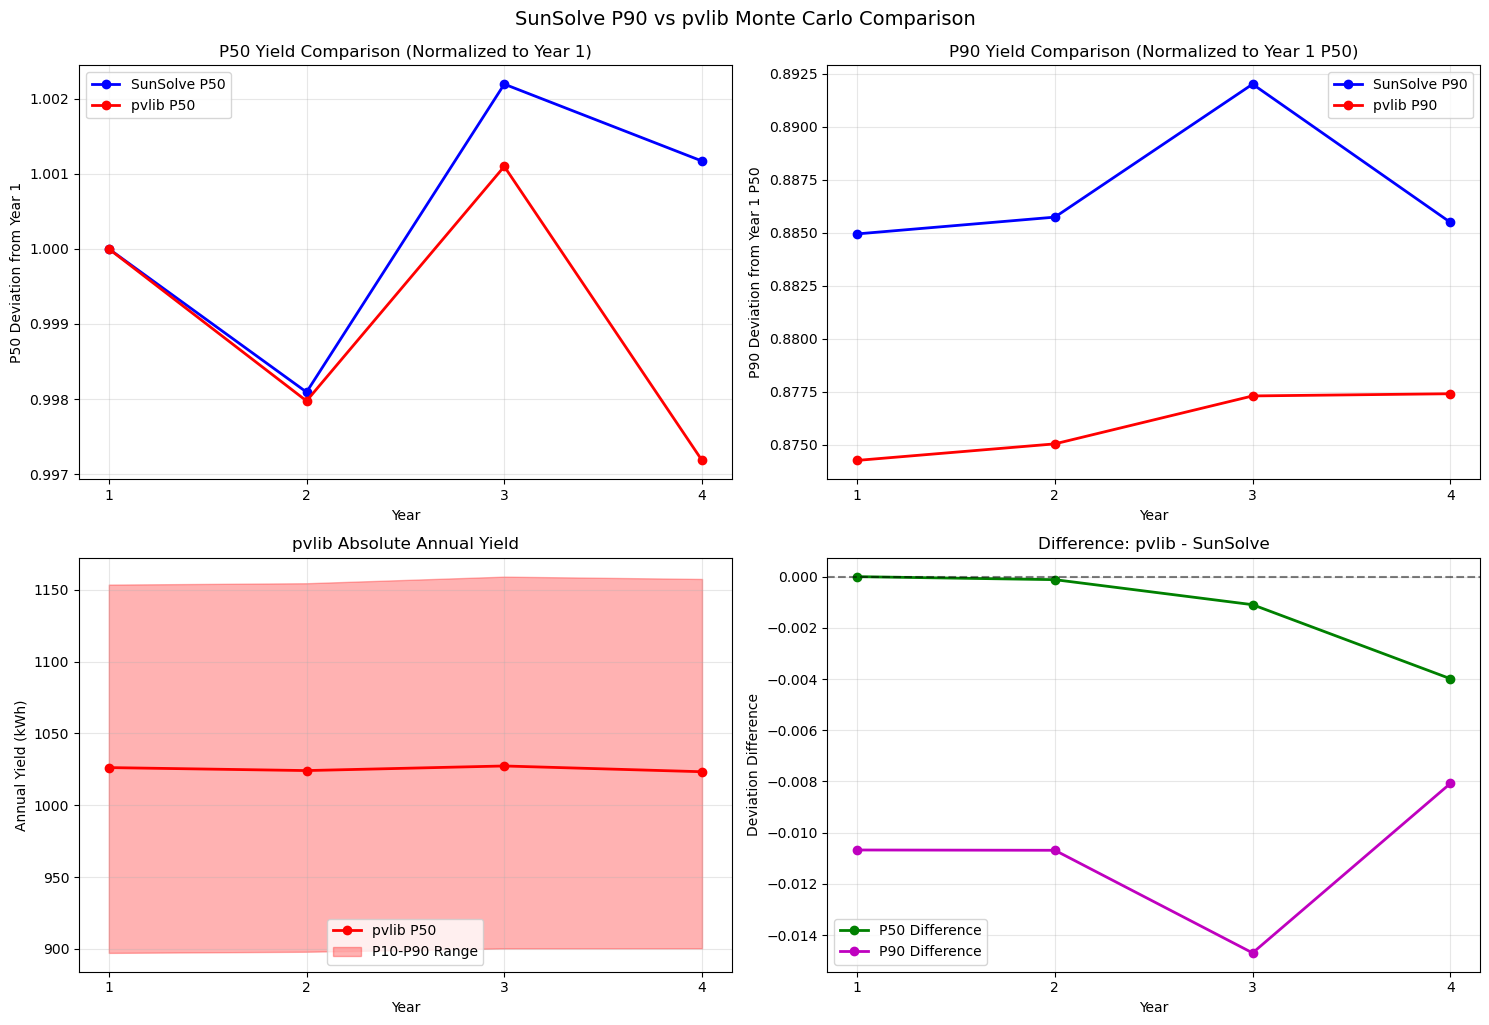

=== Numerical Comparison ===
Year	SunSolve P50	pvlib P50	Diff	SunSolve P90	pvlib P90	Diff
1	1.000		1.000		0.000	0.885		0.874		-0.011
2	0.998		0.998		-0.000	0.886		0.875		-0.011
3	1.002		1.001		-0.001	0.892		0.877		-0.015
4	1.001		0.997		-0.004	0.885		0.877		-0.008

=== Summary Statistics ===
P50 Mean Absolute Difference: 0.0013
P90 Mean Absolute Difference: 0.0110
P50 Max Difference: 0.0040
P90 Max Difference: 0.0147

=== Correlation Analysis ===
P50 Correlation: 0.4563 (p-value: 0.5437)
P90 Correlation: 0.5779 (p-value: 0.4221)


In [48]:
# Comparison between SunSolve P90 and pvlib Monte Carlo Results
import matplotlib.pyplot as plt
import numpy as np

# Extract SunSolve P90 results (normalized values)
sunsolve_p50_deviations = []
sunsolve_p90_deviations = []

# Parse the summary to extract P50 and P90 values for each year
for year in range(N_YEARS):
    # SunSolve results are normalized to P50 deviation
    if year < len(summary.YearlyP50Deviation):
        p50_dev = summary.YearlyP50Deviation[year].Value
        sunsolve_p50_deviations.append(p50_dev)
        
        # Find P90 value from PValues
        p90_dev = None
        # YearlyPValue is a flat list: [Y1P50, Y1P90, Y1P95, Y2P50, Y2P90, Y2P95, ...]
        for pval in summary.YearlyPValue:
            if pval.Year == year + 1 and pval.P == 90:  # Year is 1-indexed
                p90_dev = pval.P50Deviation
                break
        
        sunsolve_p90_deviations.append(p90_dev if p90_dev else p50_dev * 0.9)  # Fallback estimate
    else:
        sunsolve_p50_deviations.append(1.0)
        sunsolve_p90_deviations.append(0.9)

# Calculate pvlib P50 and P90 as deviations from Year 1 P50
pvlib_p50_deviations = pvlib_results['yield_mean'] / pvlib_results['yield_mean'][0]
pvlib_p90_deviations = pvlib_results['yield_p90'] / pvlib_results['yield_mean'][0]

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

years = np.arange(1, N_YEARS + 1)

# Plot 1: P50 Comparison
axes[0,0].plot(years, sunsolve_p50_deviations, 'bo-', label='SunSolve P50', linewidth=2, markersize=6)
axes[0,0].plot(years, pvlib_p50_deviations, 'ro-', label='pvlib P50', linewidth=2, markersize=6)
axes[0,0].set_title('P50 Yield Comparison (Normalized to Year 1)')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('P50 Deviation from Year 1')
axes[0,0].set_xticks(years)  # Force integer ticks
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: P90 Comparison
axes[0,1].plot(years, sunsolve_p90_deviations, 'bo-', label='SunSolve P90', linewidth=2, markersize=6)
axes[0,1].plot(years, pvlib_p90_deviations, 'ro-', label='pvlib P90', linewidth=2, markersize=6)
axes[0,1].set_title('P90 Yield Comparison (Normalized to Year 1 P50)')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('P90 Deviation from Year 1 P50')
axes[0,1].set_xticks(years)  # Force integer ticks
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Absolute Yield Comparison (pvlib only, as SunSolve gives relative values)
axes[1,0].plot(years, pvlib_results['yield_mean'], 'ro-', label='pvlib P50', linewidth=2, markersize=6)
axes[1,0].fill_between(years, pvlib_results['yield_p10'], pvlib_results['yield_p90'], 
                       alpha=0.3, color='red', label='P10-P90 Range')
axes[1,0].set_title('pvlib Absolute Annual Yield')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Annual Yield (kWh)')
axes[1,0].set_xticks(years)  # Force integer ticks
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Difference between methods
p50_diff = np.array(pvlib_p50_deviations) - np.array(sunsolve_p50_deviations)
p90_diff = np.array(pvlib_p90_deviations) - np.array(sunsolve_p90_deviations)

axes[1,1].plot(years, p50_diff, 'go-', label='P50 Difference', linewidth=2, markersize=6)
axes[1,1].plot(years, p90_diff, 'mo-', label='P90 Difference', linewidth=2, markersize=6)
axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1,1].set_title('Difference: pvlib - SunSolve')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Deviation Difference')
axes[1,1].set_xticks(years)  # Force integer ticks
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('SunSolve P90 vs pvlib Monte Carlo Comparison', y=1.02, fontsize=14)
plt.show()

# Print numerical comparison
print("=== Numerical Comparison ===")
print("Year\tSunSolve P50\tpvlib P50\tDiff\tSunSolve P90\tpvlib P90\tDiff")
for i, year in enumerate(years):
    print(f"{year}\t{sunsolve_p50_deviations[i]:.3f}\t\t{pvlib_p50_deviations[i]:.3f}\t\t{p50_diff[i]:.3f}\t{sunsolve_p90_deviations[i]:.3f}\t\t{pvlib_p90_deviations[i]:.3f}\t\t{p90_diff[i]:.3f}")

# Summary statistics
print(f"\n=== Summary Statistics ===")
print(f"P50 Mean Absolute Difference: {np.mean(np.abs(p50_diff)):.4f}")
print(f"P90 Mean Absolute Difference: {np.mean(np.abs(p90_diff)):.4f}")
print(f"P50 Max Difference: {np.max(np.abs(p50_diff)):.4f}")
print(f"P90 Max Difference: {np.max(np.abs(p90_diff)):.4f}")

# Calculate correlation
from scipy.stats import pearsonr
p50_corr, p50_p_val = pearsonr(sunsolve_p50_deviations, pvlib_p50_deviations)
p90_corr, p90_p_val = pearsonr(sunsolve_p90_deviations, pvlib_p90_deviations)

print(f"\n=== Correlation Analysis ===")
print(f"P50 Correlation: {p50_corr:.4f} (p-value: {p50_p_val:.4f})")
print(f"P90 Correlation: {p90_corr:.4f} (p-value: {p90_p_val:.4f})")